In [1]:
# Imports
import os
import shutil
import numpy as np
import cv2
import random
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    BatchNormalization,
    UpSampling2D,
    concatenate,
)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from keras import backend as K
from keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx
from patchify import patchify, unpatchify
import pandas as pd

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FN = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
        recall = TP / (TP + FN + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FP = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
        precision = TP / (TP + FP + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [3]:
# Load the model you trained in task5_training.ipynb
patch_size = 256
example_file_name = f"victoria_233182_unet_model_new_RETAKE_{patch_size}px.h5"
model = load_model(example_file_name, custom_objects={"f1": f1})

# Load the test image as grayscale
task5_test_image_path = 'task5_test_image.png'
try:
    image = cv2.imread(task5_test_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image could not be loaded. Check the file path.")
    print(f"Loaded image shape (grayscale): {image.shape}")

    # Add channel dimension for model input compatibility
    image_with_channel = image[..., np.newaxis]  # Shape: (height, width, 1)
    image_with_batch = np.expand_dims(image_with_channel, axis=0)  # Shape: (1, height, width, 1)
    print(f"Image shape for model input: {image_with_batch.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Loaded image shape (grayscale): (3006, 4112)
Image shape for model input: (1, 3006, 4112, 1)


In [4]:
def crop(image):
    # converting the reference image to grayscale for edge detection
    if image.shape == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # thresholding the reference image to create a binary version for edge detection
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # finding contours
    contours, _ = cv2.findContours(
        binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # finding the bounding box of the largest contour in the image
    largest_contour = max(contours, key=cv2.contourArea)
    rx, ry, rw, rh = cv2.boundingRect(largest_contour)

    # calculating the center and size for a square bounding box
    side_length = max(rw, rh)
    x_center = rx + rw // 2
    y_center = ry + rh // 2

    # calculating the new square bounding box coordinates
    x = max(0, x_center - side_length // 2)
    y = max(0, y_center - side_length // 2)

    # making sure the bounding box fits within the image dimensions
    x = min(x, image.shape[1] - side_length)
    y = min(y, image.shape[0] - side_length)

    coordinates = (x, y)

    # cropping the original image within the adjusted square bounding box
    cropped_image_square = image[y : y + side_length, x : x + side_length]

    # For checking the images and masks uncomment
    # plt.figure(figsize=(6, 6))
    # plt.imshow(cv2.cvtColor(cropped_image_square, cv2.COLOR_BGR2RGB))
    # plt.axis("off")
    # plt.show()

    return cropped_image_square, coordinates


def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified
        patch size.

    This function calculates the amount of padding needed for both the height
        and width of an image so that its dimensions become divisible by the
        given patch size. The padding is applied evenly to both sides of each
        dimension (top and bottom for height, left and right for width). If
        the padding amount is odd, one extra pixel is added to the bottom or
        right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape
        is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be
        divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of
        channels as the input. Its dimensions are adjusted to be divisible by
        the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(
        image,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        cv2.BORDER_CONSTANT,
        value=0,
    )

    return padded_image


def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FN = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
        recall = TP / (TP + FN + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        FP = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
        precision = TP / (TP + FP + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [5]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


Cropped image shape: (2737, 2737)
Bounding box: (x=779, y=74, w=779, h=74)


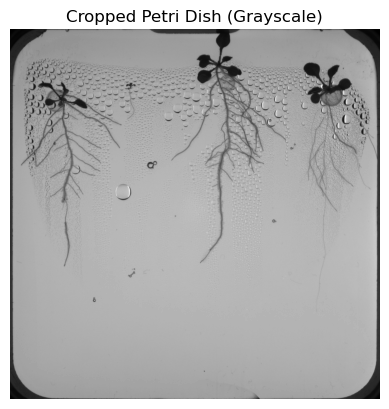

In [6]:
# Find the petri dish
cropped_img, bounding_box = crop(image)
x, y = bounding_box
cropped_img,bounding_box = crop(image)
w, h = bounding_box
print(f"Cropped image shape: {cropped_img.shape}")
print(f"Bounding box: (x={x}, y={y}, w={w}, h={h})")
plt.imshow(cropped_img, cmap='gray')  # Set colormap to gray
plt.axis('off')
plt.title("Cropped Petri Dish (Grayscale)")
plt.show()


In [7]:
def pad_image(image, patch_size):
    h, w = image.shape
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Use mirror padding to avoid black borders
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    return padded_image, (top, bottom, left, right)


In [8]:
patch_size = cropped_img.shape

(2816, 2816)


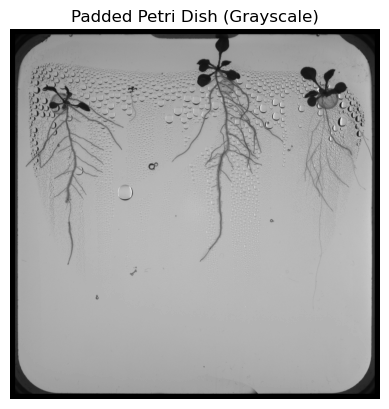

In [9]:
# Pad the petri dish
patch_size_value = 256
petri_dish_padded, padding_info = pad_image(cropped_img, patch_size_value)
print(petri_dish_padded.shape)
plt.imshow(petri_dish_padded, cmap='gray')
plt.axis('off')
plt.title("Padded Petri Dish (Grayscale)")
plt.show()

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'Prediction')

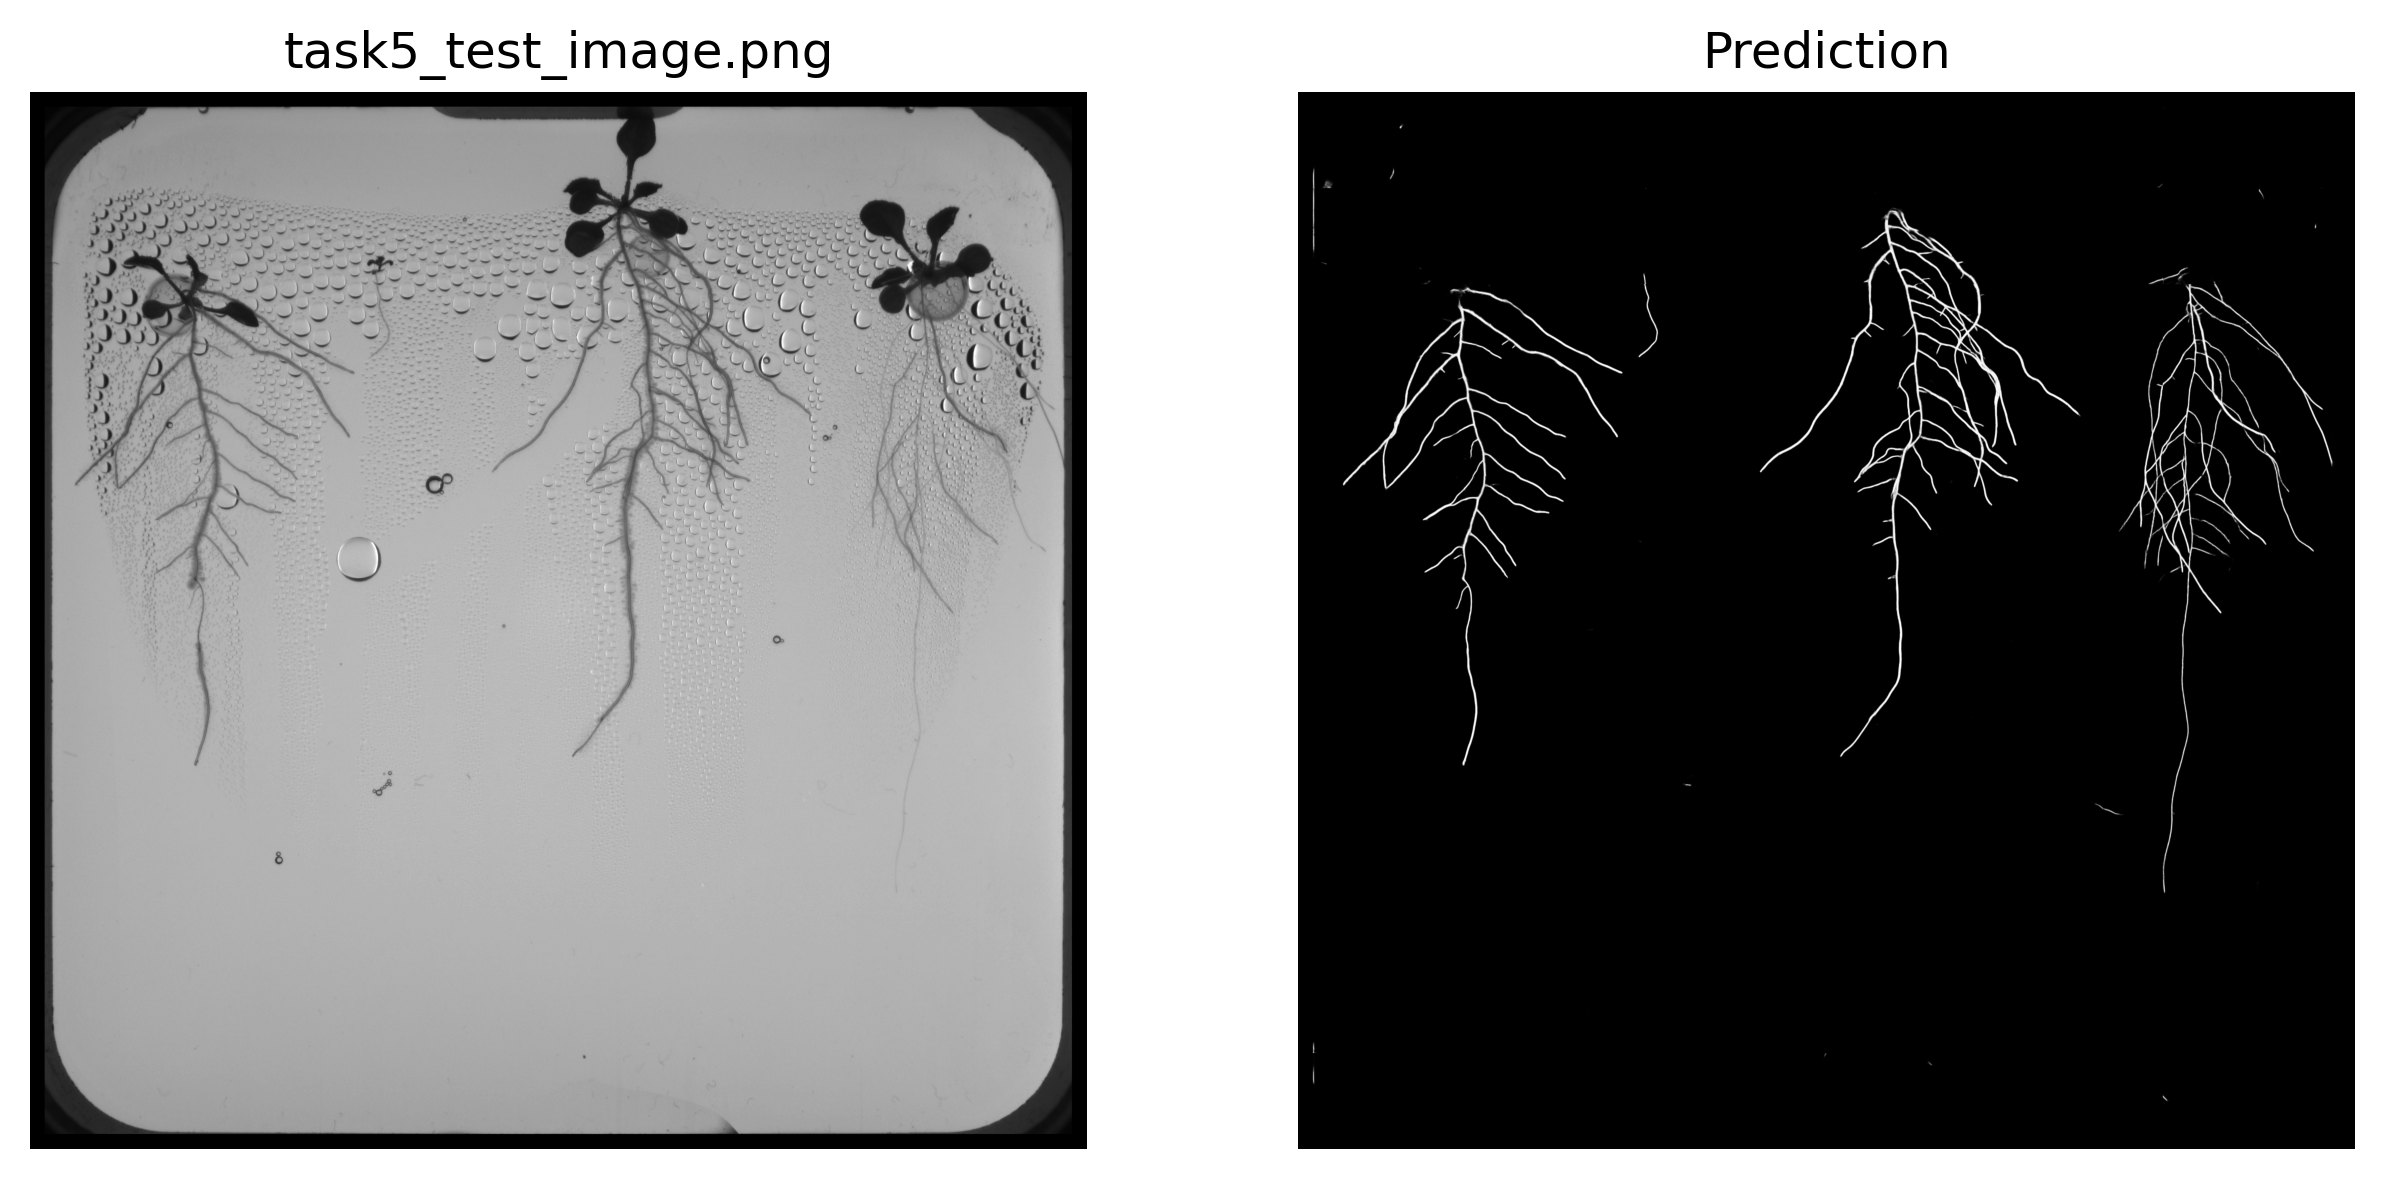

In [10]:
# PATCH
def extract_patches(image, patch_size):
    patches = []
    h, w = image.shape  # Grayscale image has only two dimensions
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue
            # Add channel dimension
            patch = np.expand_dims(patch, axis=-1)
            patch = patch.astype("float32") / 255.0
            patches.append(patch)
    return np.array(patches)

# Extract patches from the padded petri dish image
patches = extract_patches(petri_dish_padded, patch_size_value)

# PREDICT
predicted_patches = [model.predict(np.expand_dims(patch, axis=0))[0] for patch in patches]
predicted_mask = np.zeros(petri_dish_padded.shape[:2])

patch_idx = 0
for i in range(0, petri_dish_padded.shape[0], patch_size_value):
    for j in range(0, petri_dish_padded.shape[1], patch_size_value):
        predicted_mask[i:i+patch_size_value, j:j+patch_size_value] = predicted_patches[patch_idx][:, :, 0]
        patch_idx += 1

# UNPATCH
def unpad_image(image, padding_info):
    top, bottom, left, right = padding_info  # Unpack the padding information
    return image[top:image.shape[0] - bottom, left:image.shape[1] - right]


# Reconstruct the predicted mask
predicted_mask_corrected = unpad_image(predicted_mask, padding_info)

f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [11]:
predicted_mask.shape, petri_dish_padded.shape

((2816, 2816), (2816, 2816))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [12]:
# Apply the corrections

predicted_mask_corrected.shape

(2737, 2737)

In [13]:
# Apply the corrections
predicted_mask_corrected = (predicted_mask_corrected > 0.5).astype(np.uint8)

predicted_mask_corrected.shape

(2737, 2737)

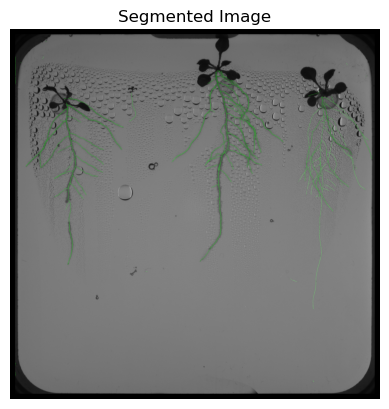

In [14]:
def draw_mask(image, mask_generated):
    # converting grayscale image to RGB
    if len(image.shape) == 2:  # Grayscale check
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # ensuring the mask is binary (0 or 1)
    mask_binary = (mask_generated > 0.5).astype(np.uint8)

    # creating a colored mask
    colored_mask = np.zeros_like(image, dtype="uint8")
    colored_mask[mask_binary == 1] = [0, 255, 0]  # Green

    # blending the original image with the colored mask
    blended_image = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

    return blended_image



segmented_image = draw_mask(petri_dish_padded, predicted_mask)

# displaying the image using Matplotlib
plt.imshow(
    cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
)  # converting BGR to RGB for correct colors
plt.axis("off")  # Hide axes for better visualization
plt.title("Segmented Image")
plt.show()


In [15]:
print(f"Overlay Image Shape: {segmented_image.shape}")
print(f"Corrected Mask Shape: {predicted_mask_corrected.shape}")
print(f"Root Mask Shape: {predicted_mask_corrected.shape}")


Overlay Image Shape: (2816, 2816, 3)
Corrected Mask Shape: (2737, 2737)
Root Mask Shape: (2737, 2737)


In [16]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
# Ensure the predicted mask shape matches the original image shape
predicted_mask_corrected_resized = cv2.resize(predicted_mask_corrected, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
assert(predicted_mask_corrected_resized.shape == image.shape)
#cv2.imwrite('task5_test_image_prediction_victoria_233182_RETAKE.png', mask_image)

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.